In [2]:
from Analysis.spiking_autocorrelegram import unit_autocorrelegram
from Analysis.utils import filter_opto_data

from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1



[2024-05-16 11:30:45,872][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-05-16 11:30:45,906][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


In [91]:
nwb_file_name = "Winnie20220717_.nwb"
pos_interval = "pos 3 valid times"

nwb_file_name = "Yoshi20220513_.nwb"
pos_interval = "pos 3 valid times"

place_field_list = []
for encoding in ["_opto_control_interval","_opto_test_interval", "_stimulus_on_interval"]:

    key = {
        "nwb_file_name": nwb_file_name,
    }
    decode_key = {**key, "encoding_interval": pos_interval + encoding}

    fit_model = (
        SortedSpikesDecodingV1
        & decode_key & "sorted_spikes_group_name NOT LIKE 'manual_full_day'"
    ).fetch_model()

    # get place fields
    place_field = list(fit_model.encoding_model_.values())[0]["place_fields"]
    place_field_list.append(place_field)
    
    bin_centers = list(fit_model.encoding_model_.values())[0]['environment'].place_bin_centers_

In [92]:
list(fit_model.encoding_model_.values())[0]['environment'].place_bin_centers_

array([[  0.99197367],
       [  2.97592101],
       [  4.95986835],
       [  6.94381569],
       [  8.92776303],
       [ 10.91171037],
       [ 12.89565771],
       [ 14.87960505],
       [ 16.86355239],
       [ 18.84749973],
       [ 20.83144707],
       [ 22.81539441],
       [ 24.79934175],
       [ 26.78328909],
       [ 28.76723643],
       [ 30.75118377],
       [ 32.73513111],
       [ 34.71907845],
       [ 36.70302579],
       [ 38.68697314],
       [ 40.67092048],
       [ 42.65486782],
       [ 44.63881516],
       [ 46.6227625 ],
       [ 48.60670984],
       [ 50.59065718],
       [ 52.57460452],
       [ 54.55855186],
       [ 56.5424992 ],
       [ 58.52644654],
       [ 60.51039388],
       [ 62.49434122],
       [ 64.47828856],
       [ 66.4622359 ],
       [ 68.44618324],
       [ 70.43013058],
       [ 72.41407792],
       [ 74.39802526],
       [ 76.3819726 ],
       [ 78.36591994],
       [ 80.34986728],
       [ 82.33381462],
       [ 84.31776196],
       [ 86

In [93]:
place_field_list[0].shape, place_field_list[1].shape

((54, 69), (54, 69))

(0.0, 2.0)

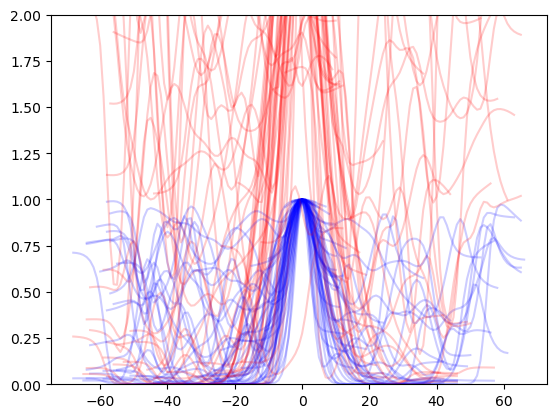

In [94]:
import matplotlib.pyplot as plt
import numpy as np
bins = np.linspace(-100,100,200)
binned_vals = [[[] for i in range(bins.size-1)] for _ in place_field_list]

for i in range(place_field_list[0].shape[0]):
    loc = np.argmax(place_field_list[0][i])
    if loc == 0 or loc == len(place_field_list[0][i]) : continue
    xx = np.arange(0, len(place_field_list[0][i]))-loc
    norm = np.max(place_field_list[0][i])
    plt.plot(xx,place_field_list[0][i]/norm, label="control",color='b',alpha=.2)
    plt.plot(xx,place_field_list[1][i]/norm, label="test",color='r',alpha=.2)
    
    bin_index = np.digitize(xx,bins)-1
    missing = np.append(np.arange(0,bin_index.min()),np.arange(bin_index.max()+1,bins.size-1))
    
    for k,data in enumerate(place_field_list):
        for j in range(len(bin_index)):
            binned_vals[k][bin_index[j]].append(data[i][j]/data[i].sum())
        for j in missing:
            binned_vals[k][j].append(0)
    # for j in range(len(bin_index)):
    #     binned_vals[0][bin_index[j]].append(place_field_list[0][i][j]/norm)
    #     binned_vals[1][bin_index[j]].append(place_field_list[1][i][j]/norm)
    # plt.legend()
    # plt.show()
    
plt.ylim(0,2)

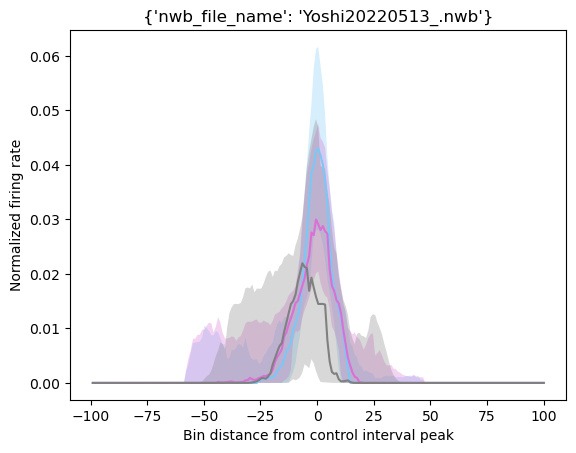

In [95]:
from Style.style_guide import interval_style

for data,color in zip(binned_vals,[interval_style["control"],interval_style["test"],'grey']):
    for d in data:
        if not d:
            d.append(0)
    mid = [np.median(data[i]) for i in range(len(binned_vals[0]))]
    lo = [np.percentile(data[i],25) for i in range(len(binned_vals[0]))]
    hi = [np.percentile(data[i],75) for i in range(len(binned_vals[0]))]
    plt.plot(bins[1:],mid,color=color)
    plt.fill_between(bins[1:],lo,hi,alpha=.3,facecolor=color)
    
    
    # plt.xlim(-50,50)
    
    plt.xlabel("Bin distance from control interval peak")
    plt.ylabel("Normalized firing rate")
    plt.title(key)


In [52]:
def alpha_blending(hex_color, alpha) :
    """ alpha blending as if on the white background.
    """
    import matplotlib
    foreground_tuple  = matplotlib.colors.hex2color(hex_color)
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return(final)

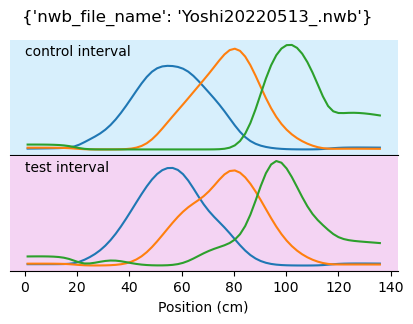

In [107]:
from Style.style_guide import interval_style

place_field_list[0].shape
# loc = np.array([.4,.5,.8])#Winnie's
loc = np.array([.4,.55,.75])#Yoshi's
ind_max = np.argmax(place_field_list[0],axis=1)
loc = loc * ind_max.max()

loc = np.array([np.argmin(np.abs(ind_max-l)) for l in loc])

# loc = (len(place_field_list[0][0])*loc).astype(int)
# ind_sort = np.argsort(np.argmax(place_field_list[0],axis=1))
# loc = ind_sort[loc]

fig, ax = plt.subplots(nrows = 2,sharex=0,figsize=(5,3))
colors = [interval_style["control"],interval_style["test"],"grey"]
colors = [alpha_blending(c,.3) for c in colors]
labels = ["control interval","test interval","stimulus on times"]
for i,fields in enumerate(place_field_list[:-1]):
    data = fields[loc]
    data = data/data.sum(axis=1)[:,None]
    ax[i].plot(bin_centers,data.T)
    ax[i].set_facecolor(colors[i])
    # ax[i].set_alpha(.1)
    ax[i].text(0,data.max()*.9,labels[i])
    # ax[i].set_xlim(bin_centers.min(),bin_centers.max())
    
for a in ax:
    a.spines[['right','top','left']].set_visible(False)
    a.set_yticks([])
    
for a in ax[:-1]:
    a.set_xticks([])
ax[-1].set_xlabel("Position (cm)")

plt.subplots_adjust(wspace=0, hspace=0.01)
plt.suptitle(key)

plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("Plots/Fig2G_yoshi.svg",format="svg")

In [35]:
# ind_max = np.argmax(place_field_list[0],axis=1)
# ind_sort = np.argsort(ind_max)
# ind_max[ind_sort]
loc

[20, 8, 9]

In [68]:
place_field_list[0][i][j]
binned_vals#[0]#[bin_index[j]]
interval_style

{'test': '#DA70D6', 'control': '#7BC8F6'}

In [6]:
SortedSpikesDecodingV1 & key & f"encoding_interval LIKE '{pos_interval}%'"

nwb_file_name name of the NWB file,unit_filter_params_name,sorted_spikes_group_name,position_group_name,decoding_param_name a name for this set of parameters,encoding_interval descriptive name of this interval list,decoding_interval descriptive name of this interval list,estimate_decoding_params whether to estimate the decoding parameters,results_path path to the results file,classifier_path path to the classifier file
Winnie20220717_.nwb,default_exclusion,04_lineartrack,pos 3 valid times,ms_lineartrack_contfrag_sorted,pos 3 valid times,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220717_.nwb,default_exclusion,04_lineartrack,pos 3 valid times,ms_lineartrack_contfrag_sorted,pos 3 valid times_opto_control_interval,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220717_.nwb,default_exclusion,04_lineartrack,pos 3 valid times,ms_lineartrack_contfrag_sorted,pos 3 valid times_opto_test_interval,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220717_.nwb,default_exclusion,04_lineartrack,pos 3 valid times,ms_lineartrack_contfrag_sorted,pos 3 valid times_stimulus_on_interval,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220717_.nwb,default_exclusion,manual_full_day,pos 3 valid times,ms_lineartrack_contfrag_sorted,pos 3 valid times,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220717_.nwb,default_exclusion,manual_full_day,pos 3 valid times,ms_lineartrack_contfrag_sorted,pos 3 valid times_opto_control_interval,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220717_.nwb,default_exclusion,manual_full_day,pos 3 valid times,ms_lineartrack_contfrag_sorted,pos 3 valid times_opto_test_interval,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220717_.nwb,default_exclusion,manual_full_day,pos 3 valid times,ms_lineartrack_contfrag_sorted,pos 3 valid times_stimulus_on_interval,pos 3 valid times,0,=BLOB=,=BLOB=
